# Weight Rank Analysis

In this notebook we look at the _rank_ of an LLM's weight matrices. Specficially, we perform a singular value decomposition and plot the singular values inspecting how quickly they fall off.

Literature:

* Hu et al. (2021) [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)
* Zhang et al. (2023) [Adaptive Budget Allocation for Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.10512)

In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from transformers import GPTNeoXForCausalLM

In [2]:
model_size = "1b"
step = 143000

In [3]:
model = GPTNeoXForCausalLM.from_pretrained(
  f"EleutherAI/pythia-{model_size}-deduped",
  revision=f"step{step}",
  cache_dir=f"./pythia-{model_size}-deduped/step{step}",
)

Pick Q, K, V transformation matrices.

In [4]:
qkv_matrices = {
    n: t for n, t in dict(model.named_parameters()).items()
    if n.endswith('query_key_value.weight')
}
list(qkv_matrices.keys())[-5:]

['gpt_neox.layers.11.attention.query_key_value.weight',
 'gpt_neox.layers.12.attention.query_key_value.weight',
 'gpt_neox.layers.13.attention.query_key_value.weight',
 'gpt_neox.layers.14.attention.query_key_value.weight',
 'gpt_neox.layers.15.attention.query_key_value.weight']

In [5]:
q_singular_vals, k_singular_vals, v_singular_vals = [], [], []
layer_names = sorted(qkv_matrices)
for layer in tqdm(layer_names):
    q_mat, k_mat, v_mat = qkv_matrices[layer].split(2048, dim=0)
    q_singular_vals.append((y := torch.svd(q_mat)[1]) / y[0])
    k_singular_vals.append((y := torch.svd(k_mat)[1]) / y[0])
    v_singular_vals.append((y := torch.svd(v_mat)[1]) / y[0])

100%|██████████| 16/16 [00:48<00:00,  3.05s/it]


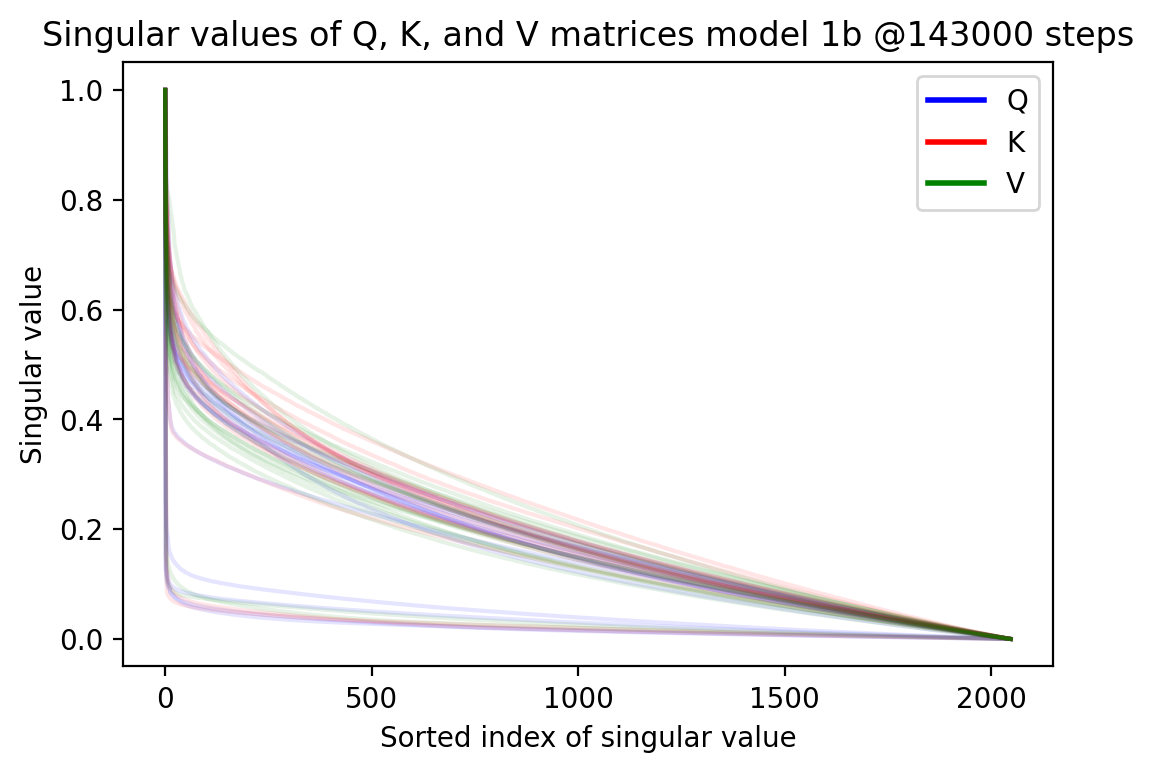

In [6]:
from matplotlib.lines import Line2D


plt.figure(figsize=(6, 4), dpi=200)

for sv in q_singular_vals:
    plt.plot(sv.detach().numpy(), alpha=0.1, color='blue', label='Q')
for sv in k_singular_vals:
    plt.plot(sv.detach().numpy(), alpha=0.1, color='red', label='K')
for sv in v_singular_vals:
    plt.plot(sv.detach().numpy(), alpha=0.1, color='green', label='V')

legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Q'),
                   Line2D([0], [0], color='red', lw=2, label='K'),
                   Line2D([0], [0], color='green', lw=2, label='V')]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f'Singular values of Q, K, and V matrices model {model_size} @{step} steps')
plt.xlabel('Sorted index of singular value')
plt.ylabel('Singular value');

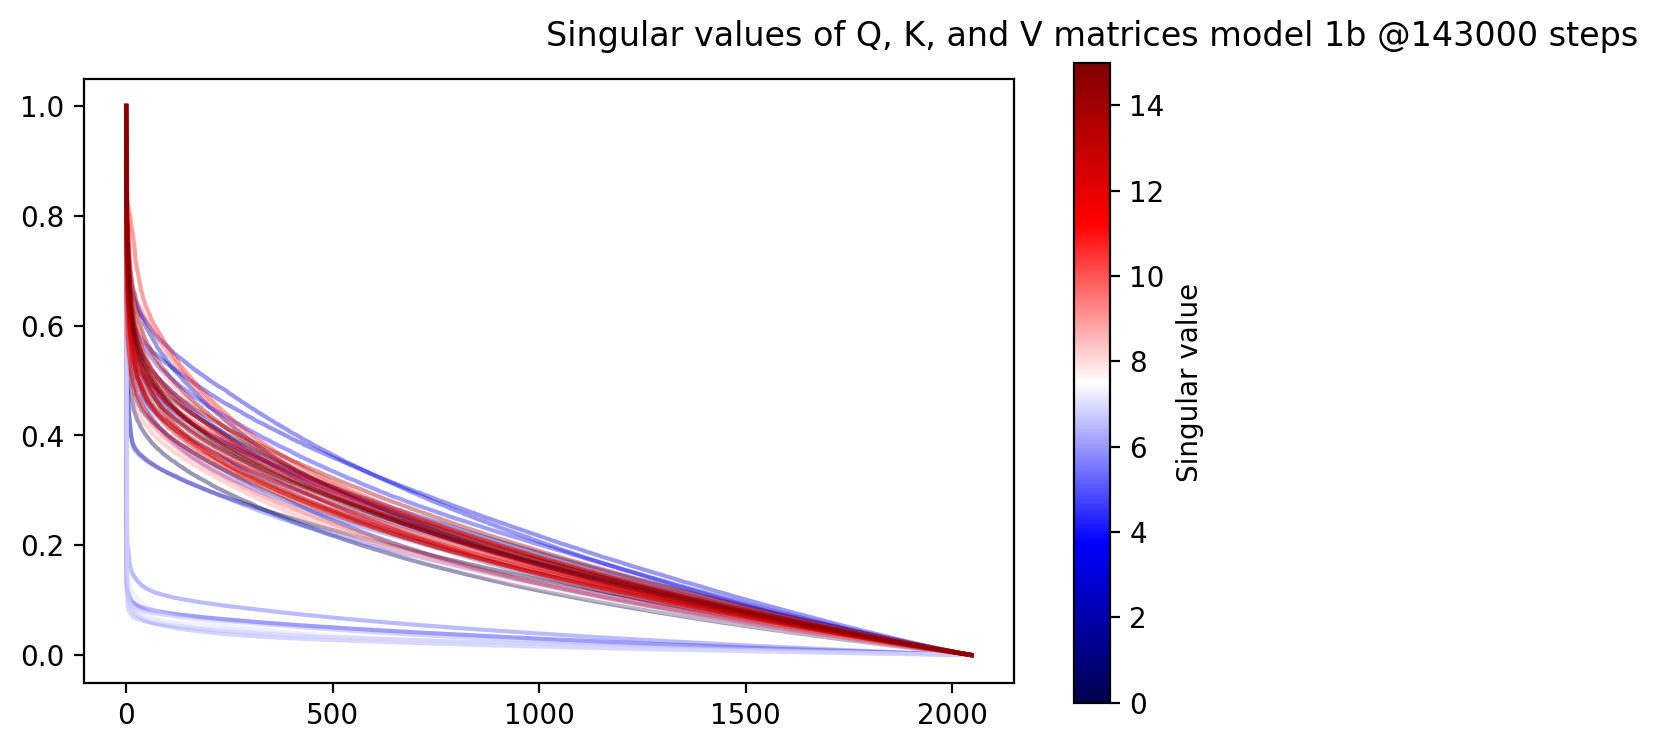

In [7]:
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize


max_layer_idx = len(q_singular_vals) - 1

plt.figure(figsize=(6, 4), dpi=200)
color_map = cm.get_cmap('seismic')

for layer_index, svs in enumerate(zip(q_singular_vals, k_singular_vals, v_singular_vals)):
    normalized_index = layer_index / max_layer_idx
    layer_color = color_map(normalized_index)
    for sv in svs:
        plt.plot(sv.detach().numpy(), alpha=0.4, color=layer_color)

cax = plt.axes([0.95, 0.1, 0.03, 0.8])
cb = ColorbarBase(cax, cmap=color_map, norm=Normalize(0, max_layer_idx))
cb.set_label('Layer index')

plt.title(f'Singular values of Q, K, and V matrices model {model_size} @{step} steps')
plt.xlabel('Sorted index of singular value')
plt.ylabel('Singular value');

# Not sure about this plot...

Clear tendency of layers closer to the output to have a lower rank.

## Inspect Layers Individually

For each of the 16 layers we plot Q, K, V singular value falloff.

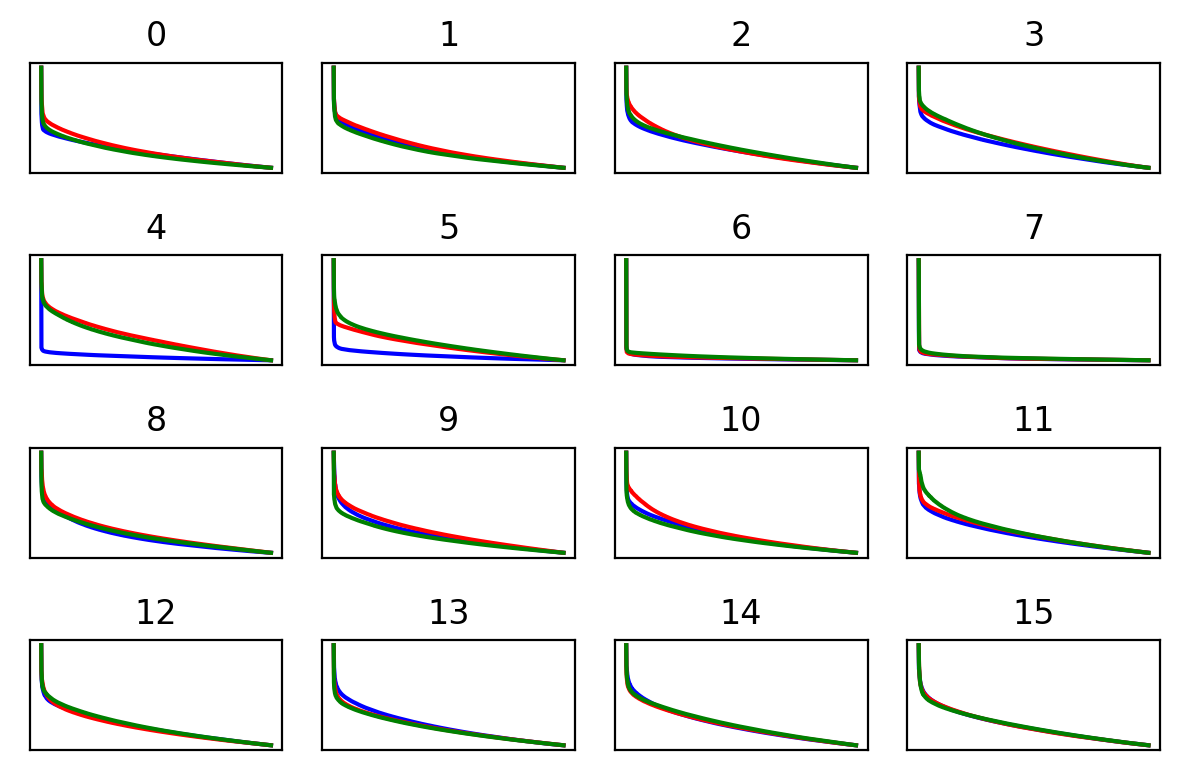

In [8]:

fig, ax = plt.subplots(4, 4, figsize=(6, 4), dpi=200)
ax = ax.flatten()

for layer_idx, layer_name in enumerate(layer_names):

    ax[layer_idx].plot(q_singular_vals[layer_idx].detach().numpy(),
        alpha=1, color='blue', label='Q')
    ax[layer_idx].plot(k_singular_vals[layer_idx].detach().numpy(),
        alpha=1, color='red', label='K')
    ax[layer_idx].plot(v_singular_vals[layer_idx].detach().numpy(),
        alpha=1, color='green', label='V')

    ax[layer_idx].set_title(layer_idx)
    
    ax[layer_idx].get_xaxis().set_ticks([])
    ax[layer_idx].get_yaxis().set_ticks([])
    # ax[layer_idx].set_title(f'Singular vals of Q/K/V {model_size} @{step}steps {layer_name.lstrip("gpt_neox.")}')
    # ax[layer_idx].legend(loc='upper right')

    # ax[layer_idx].set_xlabel('Sorted index of singular value')
    # ax[layer_idx].set_ylabel('Singular value');

plt.tight_layout();